
# Tercer Parcial 

Materia: Estadistica Aplicada 

Grupo: 042
                                                                                     
Por Ana Sofia Saucedo Garcia



In [2]:
#Librerias

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

## especializadas 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


## pmdarima

import pmdarima as pm 

In [3]:
# Paso extra para importar el archivo de internet 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
datos= pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/datos_metrorrey.csv')

Has sido contratado como asesor del director de Metrorrey, la empresa encargada de
administrar el metro en el área metropolitana de Monterrey, NL.

El director te ha proporcionado la siguiente base de datos con la información mensual del número de pasajeros y el ingreso generado por pasajes.

In [5]:
datos

,mes,miles de pasajeros,ingresos (miles de pesos)
0,1995/01,3439.000,3240.000
1,1995/02,2879.000,3623.000
2,1995/03,3103.000,3990.000
3,1995/04,3491.000,3321.000
4,1995/05,3109.000,3777.000
...,...,...,...
339,2023/04,9523.669,38799.657
340,2023/05,11891.646,58511.798
341,2023/06,10657.712,55684.063
342,2023/07,10894.497,56378.304


Responde lo que se pide:

### 1

Muestre de que tipo son las variables del dataframe, revise que no haya missing values (de haberlos imputar valores). Cersiorarse que exista una variable fecha, que sea el index y tenga una frecuencia asignada

In [6]:
datos.dtypes

mes                           object
miles de pasajeros           float64
ingresos (miles de pesos)    float64
dtype: object

observamos que en el dataframe el tipo de variable es incorrecto para la variable mes , ya que dice que es "object" y deberia de ser una variable fecha

In [7]:
## convertir en tiempo
## hacerlo index
## asignarle frecuencia 

datos['mes']=pd.to_datetime(datos['mes'],format='%Y/%m')
datos= datos.set_index('mes')
datos= datos.asfreq('MS')

In [8]:
datos.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='mes', length=344, freq='MS')

In [9]:
## missing values 

datos.isnull().sum()

miles de pasajeros           0
ingresos (miles de pesos)    0
dtype: int64

Observamos que no hay missing values

### 2

Análisis exploratorio. Utilizando código de Python genera un print() para cada una de la siguiente información:

        a) Rango de fechas
        b) Número de observaciones
        c) Valor mínimo y valor máximo del número de pasajeros

#### a)

In [10]:
# Encontrar el rango de fechas
fecha_inicio = datos.index.strftime('%Y-%m-%d').min()
fecha_fin = datos.index.strftime('%Y-%m-%d').max()

print("Fecha de inicio:", fecha_inicio)
print("Fecha de fin:", fecha_fin)
print('Rango de fechas:','[',fecha_inicio,'-',fecha_fin,']')

Fecha de inicio: 1995-01-01
Fecha de fin: 2023-08-01
Rango de fechas: [ 1995-01-01 - 2023-08-01 ]


#### b)

In [11]:
# Numero de observaciones 

obs=datos.count()[0]
print('Son',obs,'numero de observaciones en la base de datos')

Son 344 numero de observaciones en la base de datos


#### c)

In [12]:
# Valor minimo del numero de pasajeros

min_pasajeros=datos['miles de pasajeros'].min()

# Valor maximo del numero de pasajeros
max_pasajeros= datos['miles de pasajeros'].max()

print('El valor minimo del numero de pasajeros es de :',min_pasajeros,'\n El valor maximo del numero de pasajeros es de :',max_pasajeros)

El valor minimo del numero de pasajeros es de : 2397.0 
 El valor maximo del numero de pasajeros es de : 17534.523


### 3

Grafica lo siguiente: 

        a) La serie de miles de pasajeros
        b) Una media móvil centrada a 6 meses, y explica si la serie tiene tendencia o no, y si existen ciclos (subidas y caídas) y que se debe cada uno.

#### a)

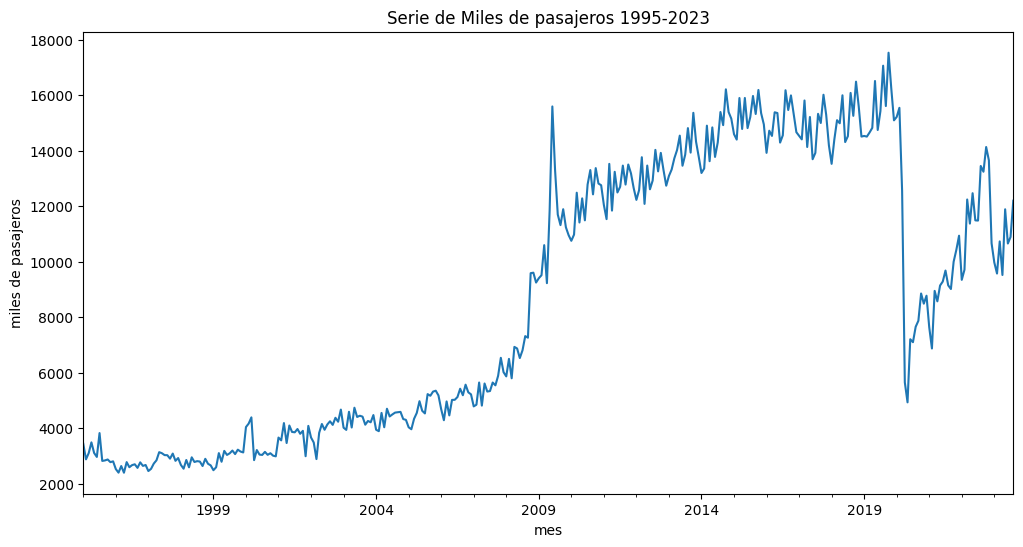

In [13]:
datos['miles de pasajeros'].plot(figsize=(12,6))
plt.xlabel('mes')
plt.ylabel('miles de pasajeros')
plt.title('Serie de Miles de pasajeros 1995-2023');


#### b)

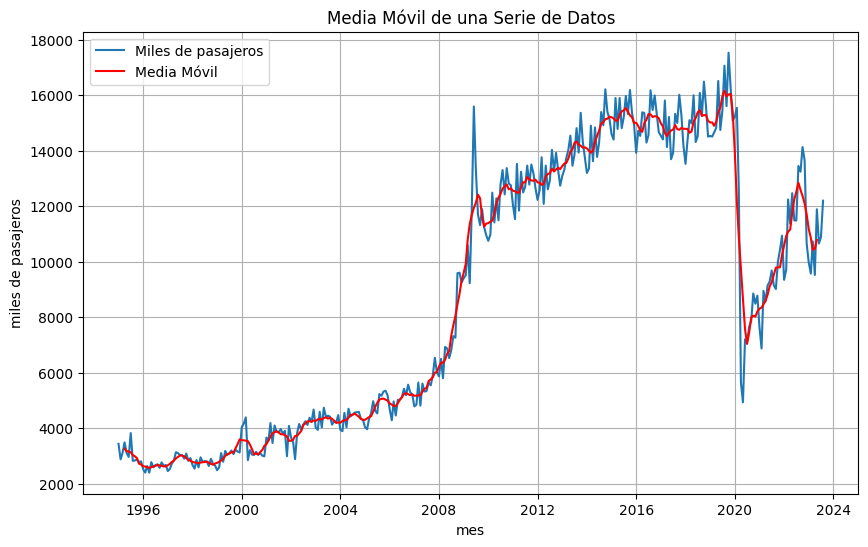

In [14]:
## Media Movil

meses = 7 

# Calcular la media móvil centrada usando .rolling
media_movil = datos['miles de pasajeros'].rolling(window=meses, center=True).mean()

# Graficar la serie original y la media móvil
plt.figure(figsize=(10, 6))
plt.plot(datos['miles de pasajeros'], label='Miles de pasajeros')
plt.plot(media_movil, label='Media Móvil', color='red')
plt.xlabel('mes')
plt.ylabel('miles de pasajeros')
plt.legend()
plt.title('Media Móvil de una Serie de Datos')
plt.grid(True)
plt.show()

La serie pareciera tener tendencia creciente sin embargo al llegar al 2020 por la pandemia del COVID tiene una gran caida por lo que puede parecer que no tiene tendencia , sin embargo se observa que en los ultimos dos años se comporta con tendencia creciente. Y se observa tambien los ciclos que son la sucesión recurrente que cae arriba y abajo de la linea de tendencia.
 

### 4

El director de Metrorrey planea hacer mantenimiento a las estaciones y los vagones, pero no sabe la fecha adecuada para hacerlo. Utiliza el modelo ETS para obtener el componente estacional de la serie y señala el mes o meses
adecuados para dar mantenimiento

In [15]:
ets1= seasonal_decompose(datos['miles de pasajeros'],model='mult')

# puede ser multiplicativa (mult) o aditiva (add) segun como se vea la grafica 

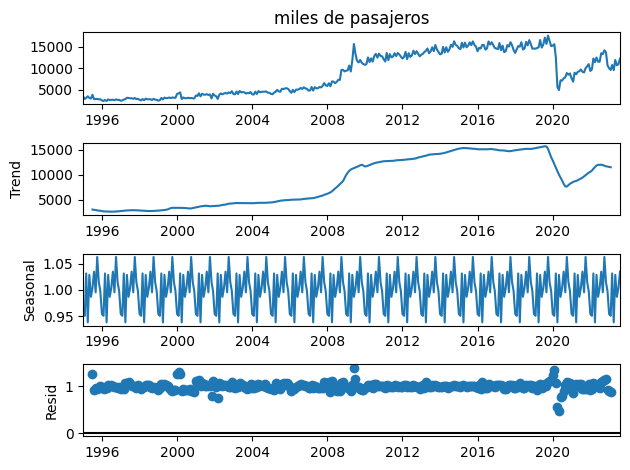

In [16]:
# Solo para observar todos los componentes
ets1.plot();

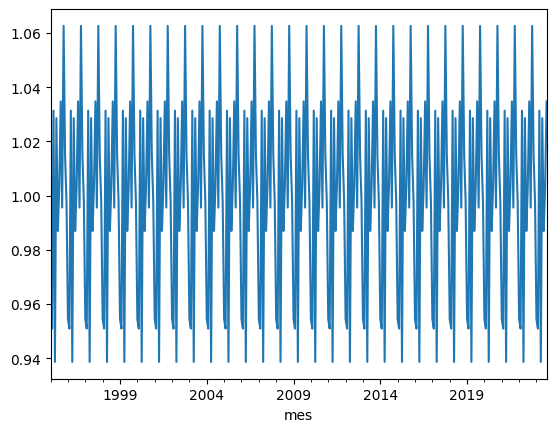

In [17]:
# Componente estacional
ets1.seasonal.plot();

In [18]:
# Componente estacional
comp_est=ets1.seasonal.head(16)
comp_est

mes
1995-01-01    0.954408
1995-02-01    0.950919
1995-03-01    1.031340
1995-04-01    0.938619
1995-05-01    1.028585
1995-06-01    0.986927
1995-07-01    1.003497
1995-08-01    1.034753
1995-09-01    0.995570
1995-10-01    1.062610
1995-11-01    1.014896
1995-12-01    0.997875
1996-01-01    0.954408
1996-02-01    0.950919
1996-03-01    1.031340
1996-04-01    0.938619
Freq: MS, Name: seasonal, dtype: float64

El componente estacional de la serie nos muestra que en el mes de Abril se presenta el nivel mas bajo del año , por lo que se recomendaria hacer mantenimiento a las estaciones y a los vagones en este mes.

### 5

El director de Metrorrey quiere saber los ingresos por pasaje y el número de pasajeros los siguientes 5 meses. Utiliza el método de Holt-Winters para pronosticar el número de pasajeros los próximos 5 meses, cada pronóstico multiplícalo por $7.1 para tener un estimado de los ingresos

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


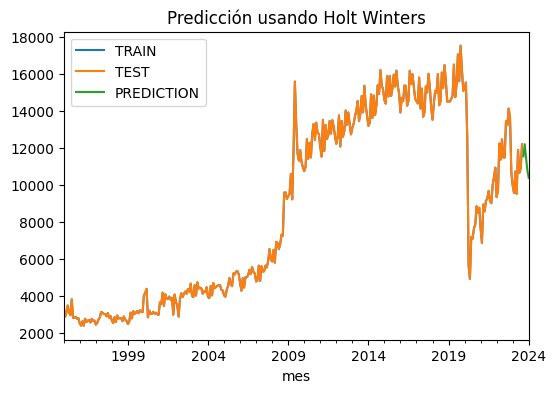

In [19]:
fitted_model = ExponentialSmoothing(datos['miles de pasajeros'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(5)
datos['miles de pasajeros'].plot(legend=True,label='TRAIN')
datos['miles de pasajeros'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Predicción usando Holt Winters');

In [20]:
print('Pronostico del numero de pasajeros para los proximos 5 meses:\n',test_predictions)

Pronostico del numero de pasajeros para los proximos 5 meses:
 2023-09-01    11552.427481
2023-10-01    12209.852476
2023-11-01    11483.302480
2023-12-01    10782.870453
2024-01-01    10391.563182
Freq: MS, dtype: float64


In [21]:
print('Estimado de los ingresos de los proximos 5 meses:\n',(test_predictions*7.1))

Estimado de los ingresos de los proximos 5 meses:
 2023-09-01    82022.235117
2023-10-01    86689.952583
2023-11-01    81531.447611
2023-12-01    76558.380218
2024-01-01    73780.098596
Freq: MS, dtype: float64


### 6

Realiza un pronóstico de los miles de pasajeros con el modelo ARIMA cumpliendo los siguientes pasos:

a) Realiza una prueba de raíz unitaria a la serie original 

In [22]:
## Prueba de dickey fuller aumentada
## H0: Serie no estacionaria
## HA: Serie estacionaria 
## P-Value < alfa rechazamos H0

prueba_adf = adfuller(datos['miles de pasajeros'])
pvalue=prueba_adf[1]
pvalue.round(2)

0.58

No rechazamos $H_0$ , es una serie no estacionaria

b) En caso de que no sea estacionaria aplica primeras diferencias, y realiza la prueba de raíz unitaria para verificar que la serie sea estacionaria

In [23]:
## primeras diferencias 

datos['pasajeros_diff']=datos['miles de pasajeros'].diff()

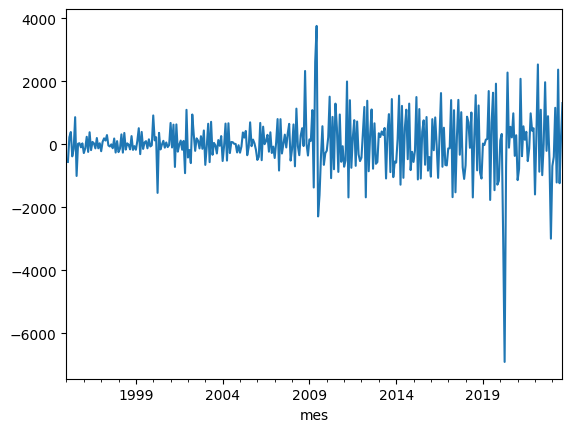

In [24]:
# Para obsevar si la serie es estacionaria 
datos['pasajeros_diff'].plot();

In [25]:
prueba_adf= adfuller(datos['pasajeros_diff'].dropna())
pvalue1= prueba_adf[1]
pvalue1.round(3)

0.0

Rechazamos $H_0$ , las primeras diferencias de 'miles de pasajeros' son una serie estacionaria

c) Si la serie no es estacionaria repite el paso b hasta que la serie sea
estacionaria.

Ya no es necesario , la serie ya es estacionaria

d) Realiza las graficas de autocorrelación de la serie estacionaria para verificar si la serie tiene o no un componente estacional

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


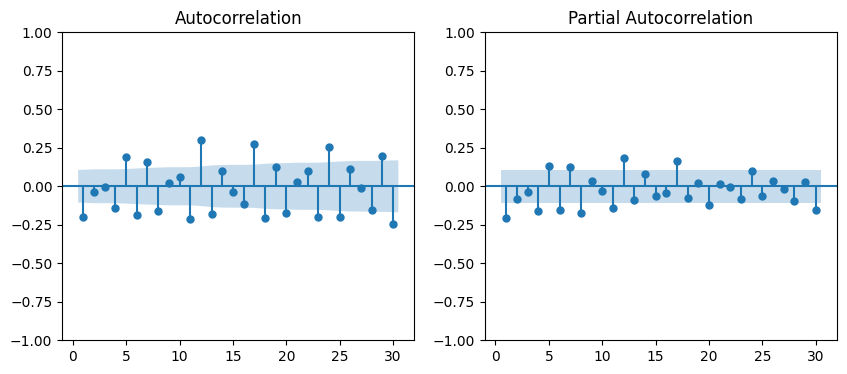

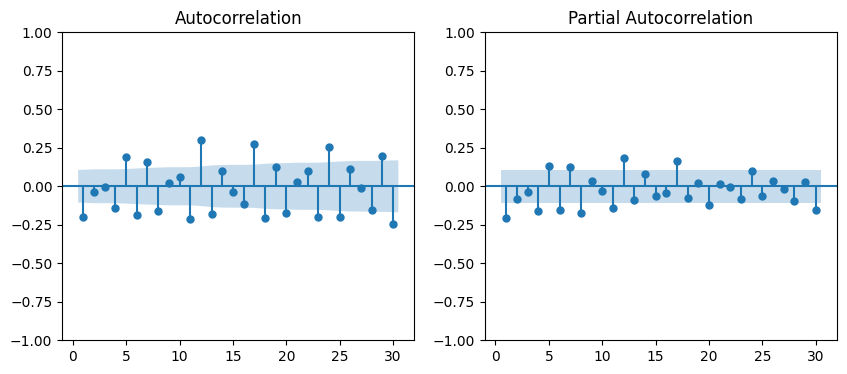

In [26]:
## graficas de autocorrelación 

ig,ax= plt.subplots(1,2,figsize=(10,4))

## 1er 
plot_acf(datos['pasajeros_diff'].dropna(),zero=False,lags=30,ax=ax[0])

## 2 da
plot_pacf(datos['pasajeros_diff'].dropna(),zero=False,lags=30,ax=ax[1])


Con las graficas de autocorrelación dado que emerge un patron que se repite , estamos ante una serie estacional , es decir, hay meses que la cantidad de pasajeros siempre sube o meses en que la cantidad de pasajeros siempre baja.

e) Utiliza auto_arima para encontrar el orden del modelo arima, dando el parámetro information_criterion prueba y muestra el resultado, con aic, bic, hqic, oob, en caso de que resulten diferente elegir aic si tu matricula termina en par, sino termina en par elegir uno distinto a aic. 

In [27]:

pm.auto_arima(datos['miles de pasajeros'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [28]:

pm.auto_arima(datos['miles de pasajeros'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='bic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [29]:

pm.auto_arima(datos['miles de pasajeros'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='hqic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [30]:

pm.auto_arima(datos['miles de pasajeros'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='oob',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

la serie es un SARIMA (1,1,3)(1,0,1,12)

f) Con el orden del modelo arima obtenido estima el modelo arima

In [31]:
## modelo

model= ARIMA(datos['miles de pasajeros'],
             order=(1,1,3),
             seasonal_order=(1,0,1,12))

results=model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                 miles de pasajeros   No. Observations:                  344
Model:             ARIMA(1, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -2772.736
Date:                            Sat, 04 Nov 2023   AIC                           5559.472
Time:                                    13:34:58   BIC                           5586.337
Sample:                                01-01-1995   HQIC                          5570.173
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9477      0.043    -21.975      0.000      -1.032      -0.863
ma.L1          0.9095      0.056   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


g) Realiza la gráfica del pronóstico a 5 meses con los intervalos de confianza
y la serie original desde 2021

In [32]:
datos['pasajeros_arima']=results.predict()

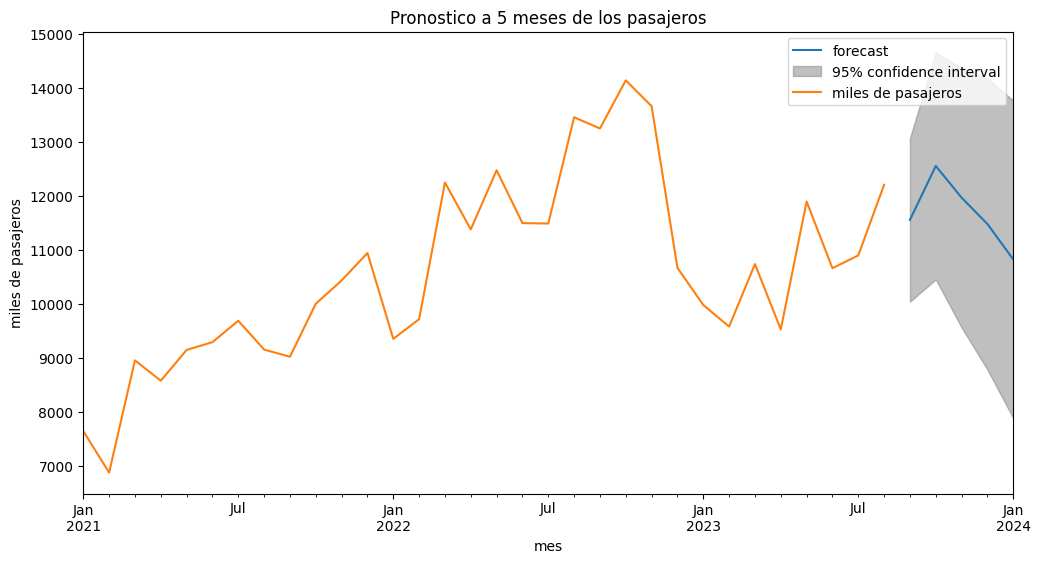

In [33]:
# grafica del pronostico futuro 


plot_predict(results,'2023-09-01','2024-01-01')
datos['miles de pasajeros']['2021-01-01':].plot(figsize=(12,6))
plt.title('Pronostico a 5 meses de los pasajeros')
plt.ylabel('miles de pasajeros')
plt.legend()
plt.show()

In [34]:
datos.tail()

,miles de pasajeros,ingresos (miles de pesos),pasajeros_diff,pasajeros_arima
mes,,,,
2023-04-01,9523.669,38799.657,-1210.233,9897.964444
2023-05-01,11891.646,58511.798,2367.977,10029.082817
2023-06-01,10657.712,55684.063,-1233.934,11565.960181
2023-07-01,10894.497,56378.304,236.785,10424.487603
2023-08-01,12201.982,57821.901,1307.485,11986.355629


h) Realiza el pronostico a 5 meses con los intervalos de confianza 

In [35]:
forecast= results.get_forecast(steps=5)
forecast_mean= forecast.predicted_mean
forecast_ci= forecast.conf_int()

In [36]:
inicio= '2023-09-01'
fin='2024-01-01'

In [37]:
pronostico_valor= forecast_mean[inicio:fin]
pronostico_intervalos= forecast_ci.loc[inicio:fin]

In [38]:
pro_pasajeros= pd.DataFrame({
    'pronostico': pronostico_valor,
    'limite inferior': pronostico_intervalos.iloc[:,0],
    'limite superior': pronostico_intervalos.iloc[:,1]
})

In [39]:
print('El pronostico de los pasajeros de los siguientes 5 meses : ')
pro_pasajeros

El pronostico de los pasajeros de los siguientes 5 meses : 


,pronostico,limite inferior,limite superior
2023-09-01,11552.710356,10038.641801,13066.778911
2023-10-01,12550.438303,10449.761071,14651.115535
2023-11-01,11963.404791,9558.096516,14368.713066
2023-12-01,11475.821277,8779.374107,14172.268448
2024-01-01,10819.610858,7878.647490,13760.574227


i) Calcula los ingresos y el intervalo de los ingreso multiplicando por $7.1

In [40]:
pro_ingresos= pd.DataFrame(pro_pasajeros*7.1)
print('El pronostico de los ingresos de los siguientes 5 meses : ')
pro_ingresos


El pronostico de los ingresos de los siguientes 5 meses : 


,pronostico,limite inferior,limite superior
2023-09-01,82024.243528,71274.356789,92774.130266
2023-10-01,89108.111953,74193.303605,104022.920300
2023-11-01,84940.174016,67862.485261,102017.862771
2023-12-01,81478.331070,62333.556161,100623.105978
2024-01-01,76819.237093,55938.397177,97700.077010
